In [84]:
from datetime import datetime, timedelta, time, date
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from plotnine import ggplot, aes, geom_linerange, scale_x_date, scale_y_continuous, scale_x_continuous, theme_minimal, theme, ggtitle, element_rect
import requests
import seaborn as sns

logging.getLogger('urllib3').setLevel(logging.WARNING)

## get snoo data

In [5]:
BASE_URL = 'https://snoo-api.happiestbaby.com'
DATA_ENDPOINT = '/ss/v2/sessions/aggregated'

#had to use a proxy to get access token- login credentials did not work for me
access_token = os.environ['snoo_access_token']

headers = {
    'Authorization': f'Bearer {access_token}',
    'accept': 'application/json',
    'content-type': 'application/json',
}

In [6]:
def get_daily_data(date):
    start_time = date.strftime('%m/%d/%Y %I:%M:%S')
    payload = {'startTime': start_time}
    response = requests.get(BASE_URL + DATA_ENDPOINT, headers=headers, params=payload)
    response.raise_for_status()
    data = response.json()
    return data

def get_aggregated_data(start_date, end_date):
    observation_period = end_date - start_date
    data = {}
    for d in range(observation_period.days):
        date = start_date + timedelta(d)
        daily_data = get_daily_data(date)
        data[date] = daily_data
    return data

In [7]:
raw_data = get_aggregated_data(datetime(2022, 6, 18), datetime(2022, 8, 27))

In [8]:
df = pd.DataFrame.from_dict(raw_data).T
df.head()

,levels,naps,longestSleep,totalSleep,daySleep,nightSleep,nightWakings
2022-06-18,"[{'sessionId': '1513203156', 'type': 'asleep',...",0,6185,13790,0,13790,6
2022-06-19,"[{'sessionId': '1327294603', 'type': 'asleep',...",3,7218,25630,12261,13369,4
2022-06-20,"[{'sessionId': '1009722615', 'type': 'asleep',...",2,9320,31230,9706,21524,4
2022-06-21,"[{'sessionId': '1060578360', 'type': 'asleep',...",4,9157,53673,22829,30844,5
2022-06-22,"[{'sessionId': '1183287652', 'type': 'asleep',...",3,9885,36685,17135,19550,5


Text(0, 0.5, 'hours of continous sleep in the snoo')

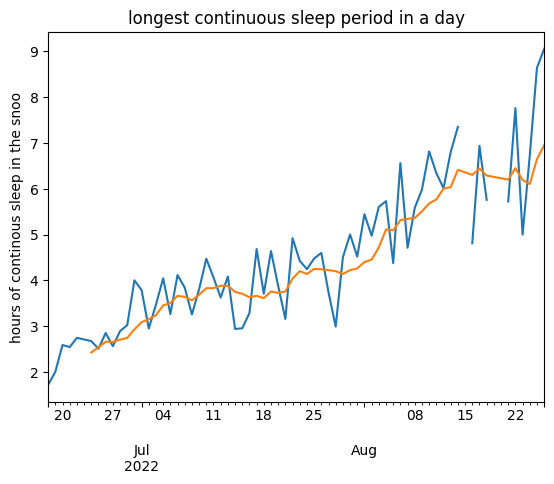

In [186]:
# missing a few days from when we were out of town
ax = df['longestSleep'].apply(lambda x: x/3600).where(lambda x: x>0).plot()
df['longestSleep'].apply(lambda x: x/3600).where(lambda x: x>0).dropna().rolling(7).mean().plot(ax=ax, label='7d rolling avg')
ax.set_title('longest continuous sleep period in a day')
ax.set_ylabel('hours of continous sleep in the snoo')

Text(0, 0.5, 'hours')

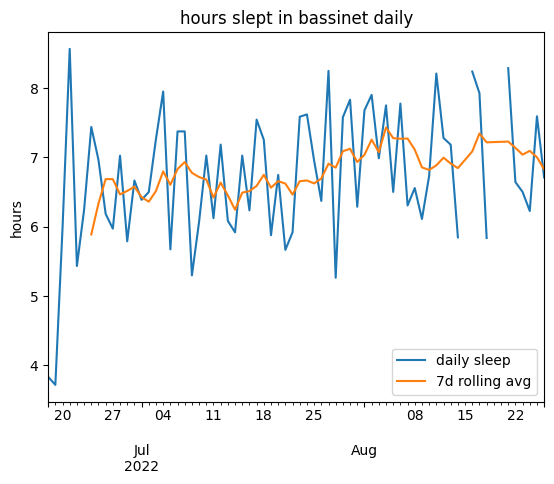

In [181]:
ax = df['nightSleep'].apply(lambda x: x/3600).where(lambda x: x>0).plot(label='daily sleep')
df['nightSleep'].apply(lambda x: x/3600).where(lambda x: x>0).dropna().rolling(7).mean().plot(ax=ax, label='7d rolling avg')
ax.set_title('hours slept in bassinet daily')
ax.legend()
ax.set_ylabel('hours')

Text(0, 0.5, 'discrete pickups')

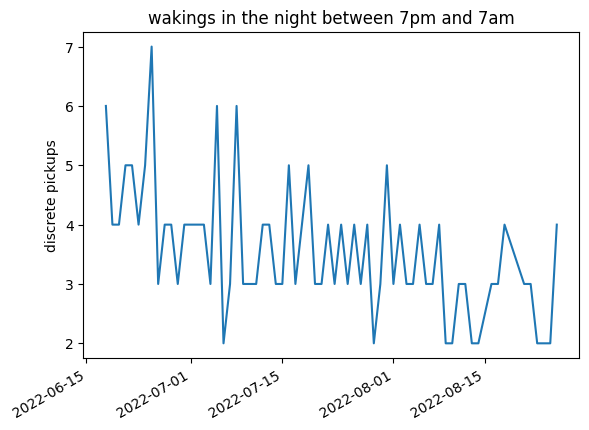

In [183]:
ax = df['nightWakings'].where(lambda x: x>0).dropna().plot()
ax.set_title('wakings in the night between 7pm and 7am')
ax.set_ylabel('discrete pickups')

Text(0.5, 1.0, 'naps')

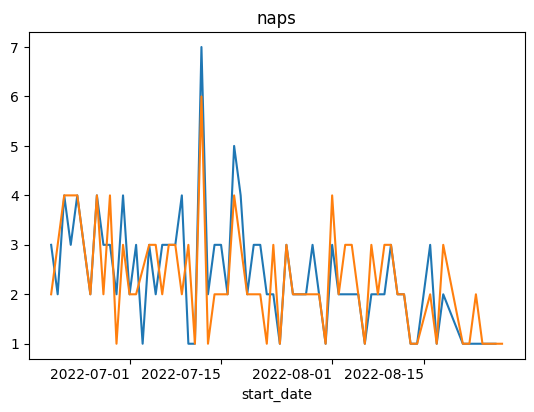

In [203]:
# not super informative since most naps happened outside the snoo, especially early on
ax = df['naps'].where(lambda x: x>0).dropna().plot()

df_sessions[(df_sessions['start_time']> time(hour=7, minute=0, second=0))&\
            (df_sessions['end_time'] < time(hour=19, minute=0, second=0))&\
            (df_sessions['type']=='asleep')&\
            (df_sessions.stateDuration>60)].groupby('start_date')['sessionId'].nunique().plot(ax=ax)
ax.set_title('naps')

### extract session data

In [4]:
session_data = []
for day in raw_data.values():
    sessions = day['levels']
    session_data.extend(sessions)

df_sessions = pd.DataFrame(session_data)
df_sessions['startTime'] = pd.to_datetime(df_sessions['startTime'])
df_sessions['endTime'] = df_sessions['startTime'] + pd.to_timedelta(df_sessions['stateDuration'], unit='s')


df_sessions['start_datetime'] = pd.to_datetime(df_sessions['startTime'], errors='coerce')
df_sessions['end_datetime'] = pd.to_datetime(df_sessions['endTime'], errors='coerce')
df_sessions['start_time'] = df_sessions['startTime'].dt.time
df_sessions['end_time'] = df_sessions['endTime'].dt.time
df_sessions['start_date'] = df_sessions['startTime'].dt.date
df_sessions['end_date'] = df_sessions['endTime'].dt.date


<Axes: xlabel='start_date', ylabel='nap_minutes'>

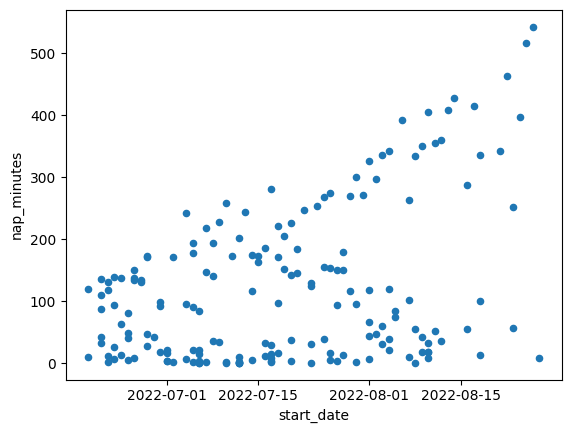

In [206]:
# tried manually defining naps according to the documentation but it doesn't seem accurate. skipping for now
df_sessions[(df_sessions['start_time']> time(hour=7, minute=0, second=0))&\
            (df_sessions['end_time'] < time(hour=19, minute=0, second=0))&\
            (df_sessions['type']=='asleep')&\
            (df_sessions.stateDuration>60)]\
    .assign(nap_minutes=lambda _df: _df['stateDuration']//60)\
.plot.scatter(x='start_date', y='nap_minutes')

<Axes: xlabel='start_date'>

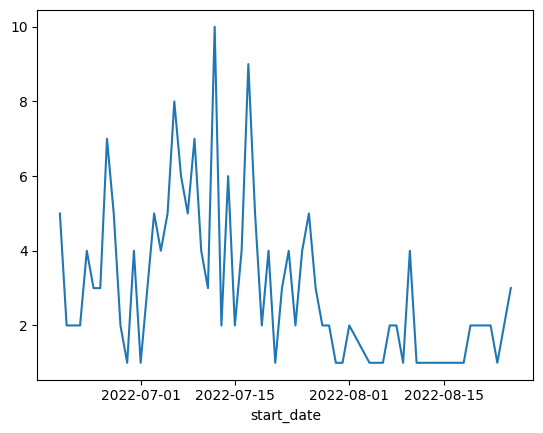

In [212]:
#soothing instances
df_sessions[(df_sessions['type']=='soothing')&(df_sessions.stateDuration>10)].groupby('start_date').size().plot()

In [78]:
def get_plot_df(df, time_format, birthday=None):
    df_no_cross = df[df['startTime'].dt.day == df['endTime'].dt.day].copy()
    df_cross = df[df['startTime'].dt.day != df['endTime'].dt.day]
    df_cross_1 = df_cross.copy()
    df_cross_2 = df_cross.copy()
    df_cross_1['end_time'] = time(hour=23, minute=59, second=59)
    df_cross_2['start_date'] = df_cross_2['start_date'] + timedelta(days=1)
    df_cross_2['start_time'] = time(hour=0, minute=0, second=0)
    rows_no_cross = df_no_cross[['start_date', 'start_time', 'end_time']]
    rows_cross_1 = df_cross_1[['start_date', 'start_time', 'end_time']]
    rows_cross_2 = df_cross_2[['start_date', 'start_time', 'end_time']]
    rows = pd.concat([rows_no_cross, rows_cross_1, rows_cross_2])
    rows['start_time'] = pd.to_datetime(rows['start_time'].apply(lambda x: x.replace(microsecond=0)), format='%H:%M:%S')
    rows['end_time'] = pd.to_datetime(rows['end_time'].apply(lambda x: x.replace(microsecond=0)), format='%H:%M:%S')
    rows['start_time_dt'] = pd.to_datetime(rows['start_time'], format=time_format).dt.time
    rows['end_time_dt'] = pd.to_datetime(rows['end_time'], format=time_format).dt.time
    rows['start_time_minutes'] = rows['start_time_dt'].apply(lambda x: x.hour * 60 + x.minute)
    rows['end_time_minutes'] = rows['end_time_dt'].apply(lambda x: x.hour * 60 + x.minute)
    if birthday:
        rows['age'] = (rows['start_date'] - birthday).apply(lambda x: int(x.days))
    return rows

In [220]:
snoo_sleep_data = get_plot_df(df_sessions[df_sessions.type=='asleep'], '%H:%M:%S', birthday=date(2022, 6, 15))

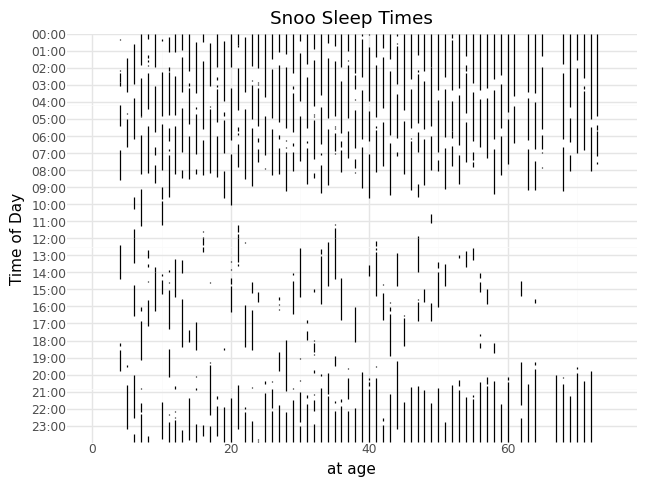

In [221]:
plot = (ggplot(mapping=aes(x='age'), data=snoo_sleep_data)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes'))
        + scale_x_continuous(name='at age', limits=(0, 75))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Snoo Sleep Times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'))
)

fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60)
ax.set_yticks(ticks)

time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)

ax.grid(True)
fig.gca().invert_yaxis()

fig.savefig('baby_sleep_times.png', bbox_inches='tight')
Image.open('baby_sleep_times.png')

In [222]:
snoo_soothing_data = get_plot_df(df_sessions[df_sessions.type=='soothing'], '%H:%M:%S', birthday=date(2022, 6, 15))

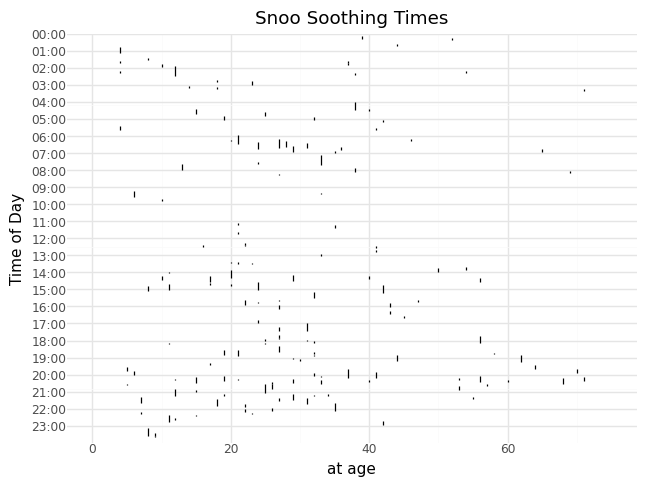

In [224]:
plot = (ggplot(mapping=aes(x='age'), data=snoo_soothing_data)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes'))
        + scale_x_continuous(name='at age', limits=(0, 75))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Snoo Soothing Times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'))
)

fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60)
ax.set_yticks(ticks)

time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)

ax.grid(True)
fig.gca().invert_yaxis()

fig.savefig('baby_sleep_times.png', bbox_inches='tight')
Image.open('baby_sleep_times.png')

## add huckleberry data

In [3]:
df_huckleberry = pd.read_csv('/Users/rmaxwell/Downloads/huckleberry_file_export.csv')
df_huckleberry['Start'] = pd.to_datetime(df_huckleberry['Start'])
df_huckleberry['End'] = pd.to_datetime(df_huckleberry['End'])
df_huckleberry['start_time'] = df_huckleberry['Start'].dt.time
df_huckleberry['end_time'] = df_huckleberry['End'].dt.time
df_huckleberry['start_date'] = df_huckleberry['Start'].dt.date
df_huckleberry['end_date'] = df_huckleberry['End'].dt.date

In [87]:
hb_sleep_data = get_plot_df(df_huckleberry[df_huckleberry['Type']=='Sleep'].rename(columns={'Start': 'startTime', 'End': 'endTime'}), '%H:%M', birthday=date(2022, 6, 15))

/Users/rmaxwell/.virtualenvs/personal/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 4 rows containing missing values.


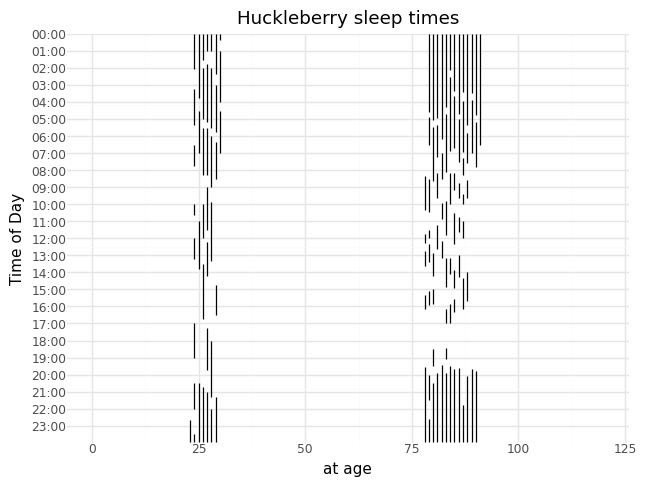

In [89]:
plot = (ggplot(mapping=aes(x='age'), data=hb_sleep_data)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes'))
        + scale_x_continuous(name='at age', limits=(0, 120))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Huckleberry sleep times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'))
)
fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60)
ax.set_yticks(ticks)

time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)

ax.grid(True)
fig.gca().invert_yaxis()

fig.savefig('baby_sleep_times.png', bbox_inches='tight')
Image.open('baby_sleep_times.png')

/Users/rmaxwell/.virtualenvs/personal/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 4 rows containing missing values.


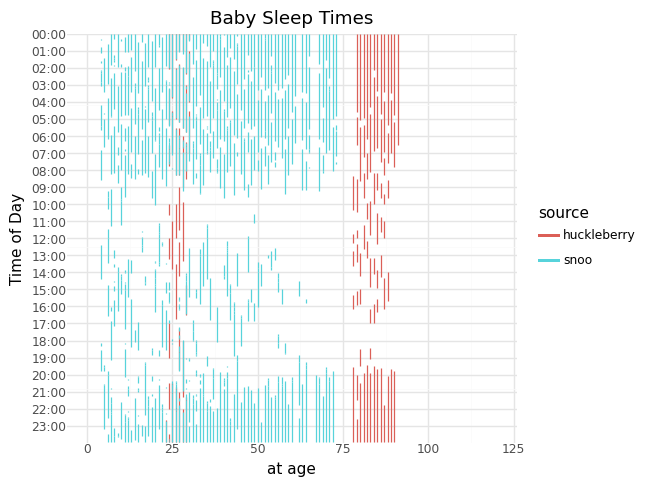

In [90]:
plot = (ggplot(mapping=aes(x='age'), data=pd.concat([snoo_sleep_data.assign(source='snoo'), hb_sleep_data.assign(source='huckleberry')]))
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes', color='source'))
        + scale_x_continuous(name='at age', limits=(0, 120))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Baby Sleep Times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'))
)
fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60)
ax.set_yticks(ticks)

time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)

ax.grid(True)
fig.gca().invert_yaxis()

fig.savefig('baby_sleep_times.png', bbox_inches='tight')
Image.open('baby_sleep_times.png')

### other huckleberry data

In [149]:
#feeding
hb_feed_data = get_plot_df(df_huckleberry[df_huckleberry['Type']=='Feed'].rename(columns={'Start': 'startTime', 'End': 'endTime'}), '%H:%M', birthday=date(2022, 6, 15))

hb_feed_data['duration'] = hb_feed_data['end_time_minutes'] - hb_feed_data['start_time_minutes']
#removing outliers where we forgot to turn off the timer :|

hb_feed_data = hb_feed_data.loc[hb_feed_data['duration'].where(lambda x: x<60).dropna().index]

<Axes: ylabel='Frequency'>

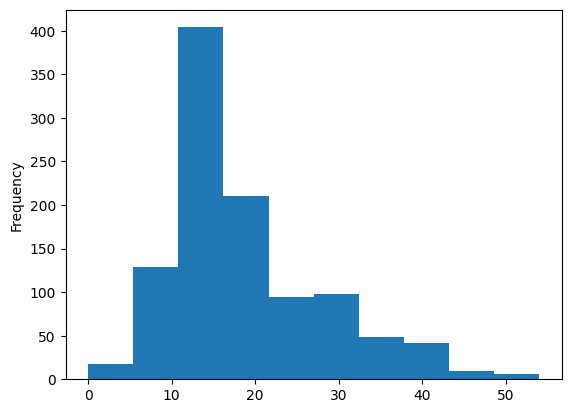

In [151]:
hb_feed_data['duration'].plot(kind='hist')

Text(0.5, 1.0, 'feed duration by age')

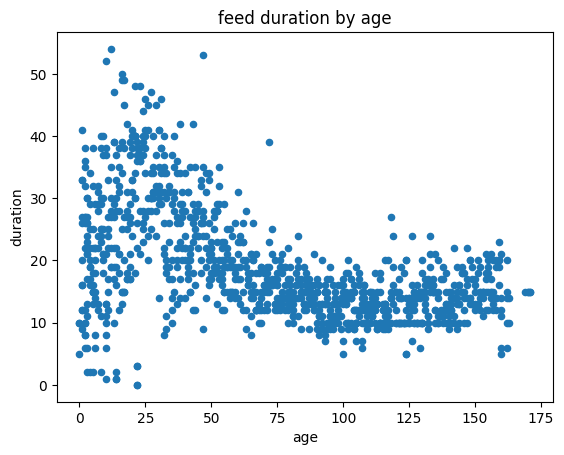

In [153]:
ax = hb_feed_data.plot.scatter(x='age', y='duration')
ax.set_title('feed duration by age')

In [148]:
df_huckleberry[df_huckleberry['Type']=='Feed']['Start Location'].value_counts()

Start Location
Breast    1033
Bottle      21
Name: count, dtype: int64

/Users/rmaxwell/.virtualenvs/personal/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 227 rows containing missing values.


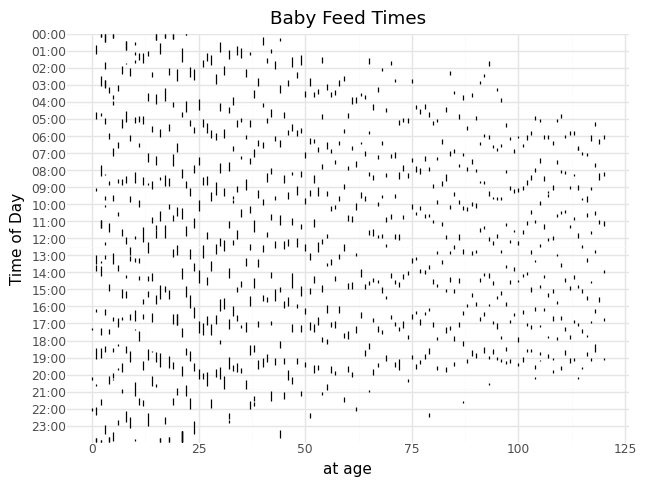

In [93]:
plot = (ggplot(mapping=aes(x='age'), data=hb_feed_data)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes'))
        + scale_x_continuous(name='at age', limits=(0, 120))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Baby Feed Times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'))
)
fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60)
ax.set_yticks(ticks)

time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)

ax.grid(True)
fig.gca().invert_yaxis()

fig.savefig('baby_sleep_times.png', bbox_inches='tight')
Image.open('baby_sleep_times.png')

### poos and wees

In [118]:
def f(x):
    if 'Both' in x:
        return 'both'
    elif 'Poo' in x:
        return 'poo'
    elif 'Pee' in x:
        return 'pee'

df_poo = df_huckleberry.loc[(df_huckleberry['Type']=='Diaper').where(lambda x: x==True).dropna().index]
df_poo['age'] = (pd.to_datetime(df_poo['start_date']) - datetime(2022, 6, 15)).apply(lambda x: x.days)
df_poo['start_time_dt'] = pd.to_datetime(df_poo['start_time'], format='%H:%M:%S').dt.time
df_poo['start_time_minutes'] = df_poo['start_time_dt'].apply(lambda x: x.hour * 60 + x.minute)

df_poo['poo_type'] = df_poo['End Condition'].apply(f)

Text(0.5, 1.0, 'diaper changes per day')

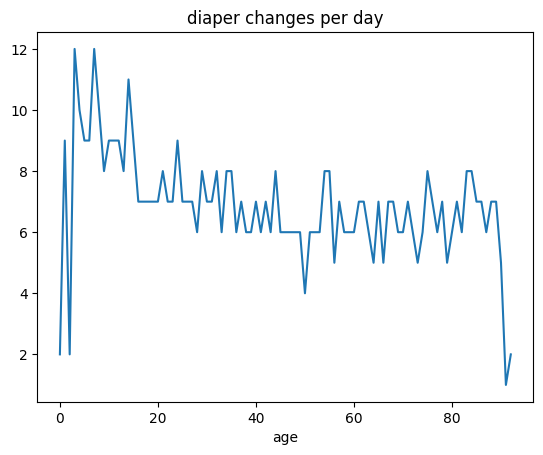

In [119]:
ax = df_poo.groupby('age').size().plot()
ax.set_title('diaper changes per day')

Text(0.5, 1.0, 'poos per day')

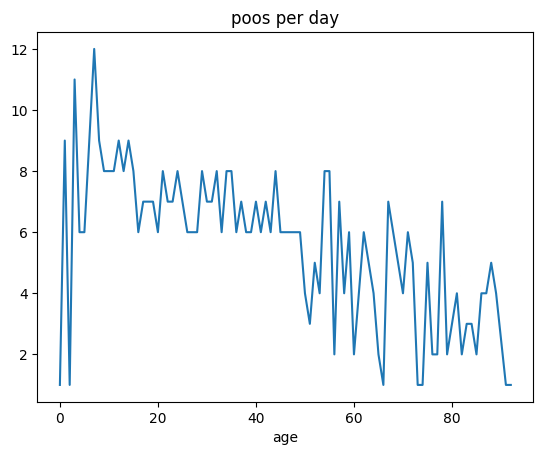

In [120]:
ax = df_poo[df_poo.poo_type!='pee'].groupby('age').size().plot()
ax.set_title('poos per day')

<Axes: xlabel='age', ylabel='start_time_minutes'>

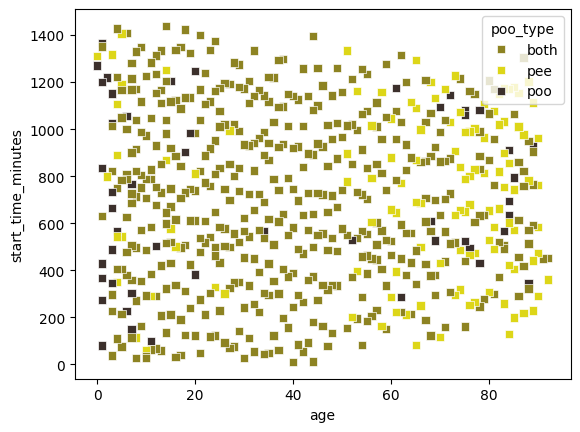

In [121]:
sns.scatterplot(data=df_poo,
                x='age', y='start_time_minutes', hue='poo_type'
                ,marker='$\u25A0$'
               ,palette=['#8D8322', '#DDD618', '#3C302C'])

# combined

In [2]:
df_combined = pd.concat([
            snoo_sleep_data.assign(source='snoo - sleep')
           ,hb_sleep_data.assign(source='huckleberry - sleep')
           ,hb_feed_data.assign(source='huckleberry - feeding')
           ,df_poo.assign(source='huckleberry - diaper')
])

/Users/rmaxwell/.virtualenvs/personal/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 868 rows containing missing values.


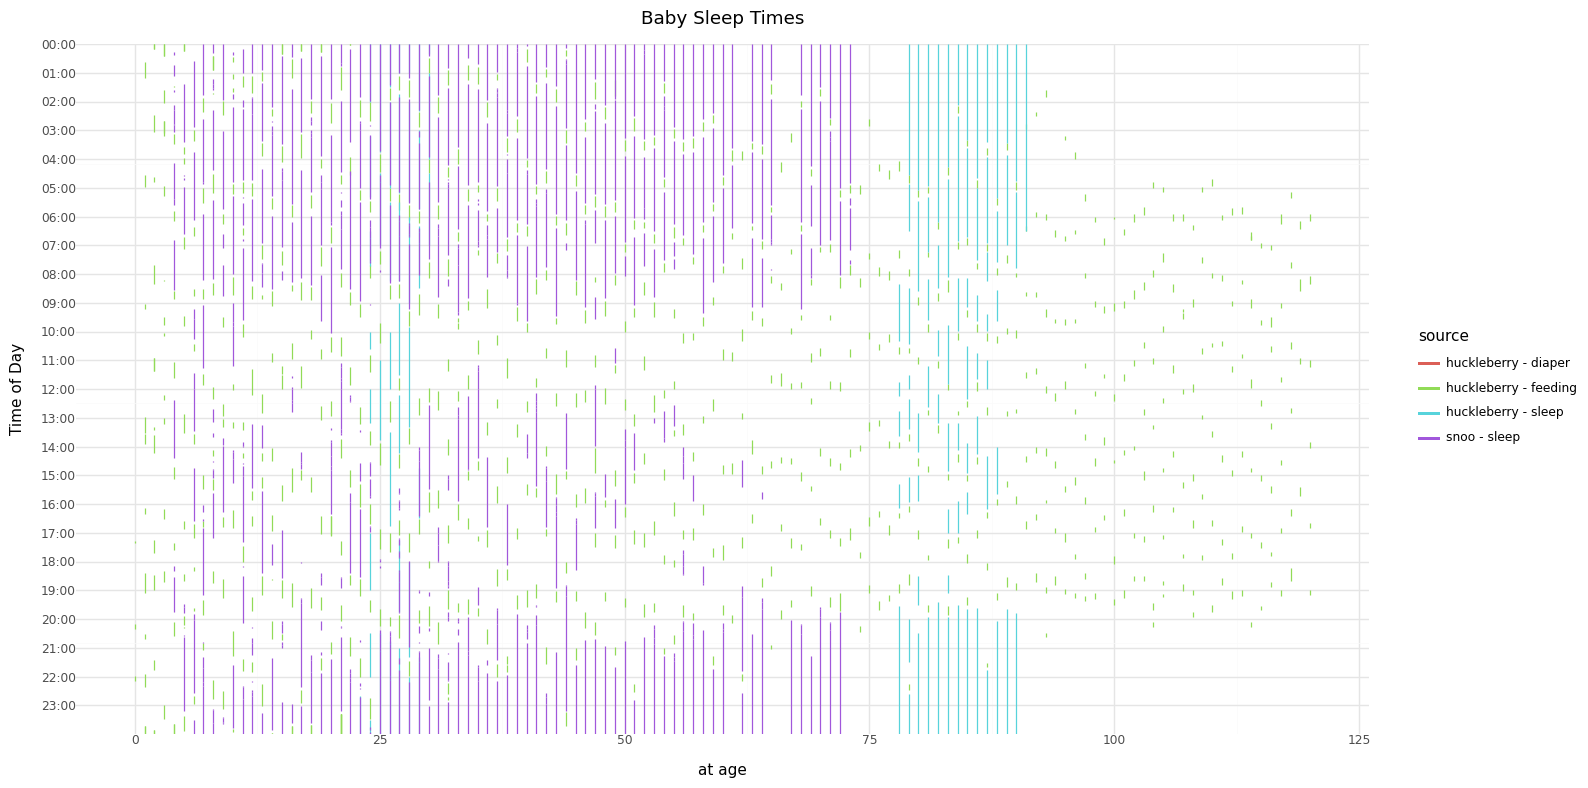

In [143]:
plot = (ggplot(mapping=aes(x='age'), data=df_combined)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes', color='source'))
        + scale_x_continuous(name='at age', limits=(0, 120))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Baby Activity Times')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'), figure_size=(16, 8)))

fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60) 
ax.set_yticks(ticks)


time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)


ax.grid(True)
ax.invert_yaxis()
ax.set_xlabel('') 
ax.set_ylabel('')
# ax2 = sns.scatterplot(data=df_poo, x='age', y='start_time_minutes', hue='poo_type',marker='$\u25AC$',palette=['#8D8322', '#DDD618', '#3C302C'], ax=fig.gca(), s=10)
# ax2.set_xlabel('') 
# ax2.set_ylabel('')

fig.savefig('baby_sleep_times.png', bbox_inches='tight')

Image.open('baby_sleep_times.png')



/Users/rmaxwell/.virtualenvs/personal/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 868 rows containing missing values.


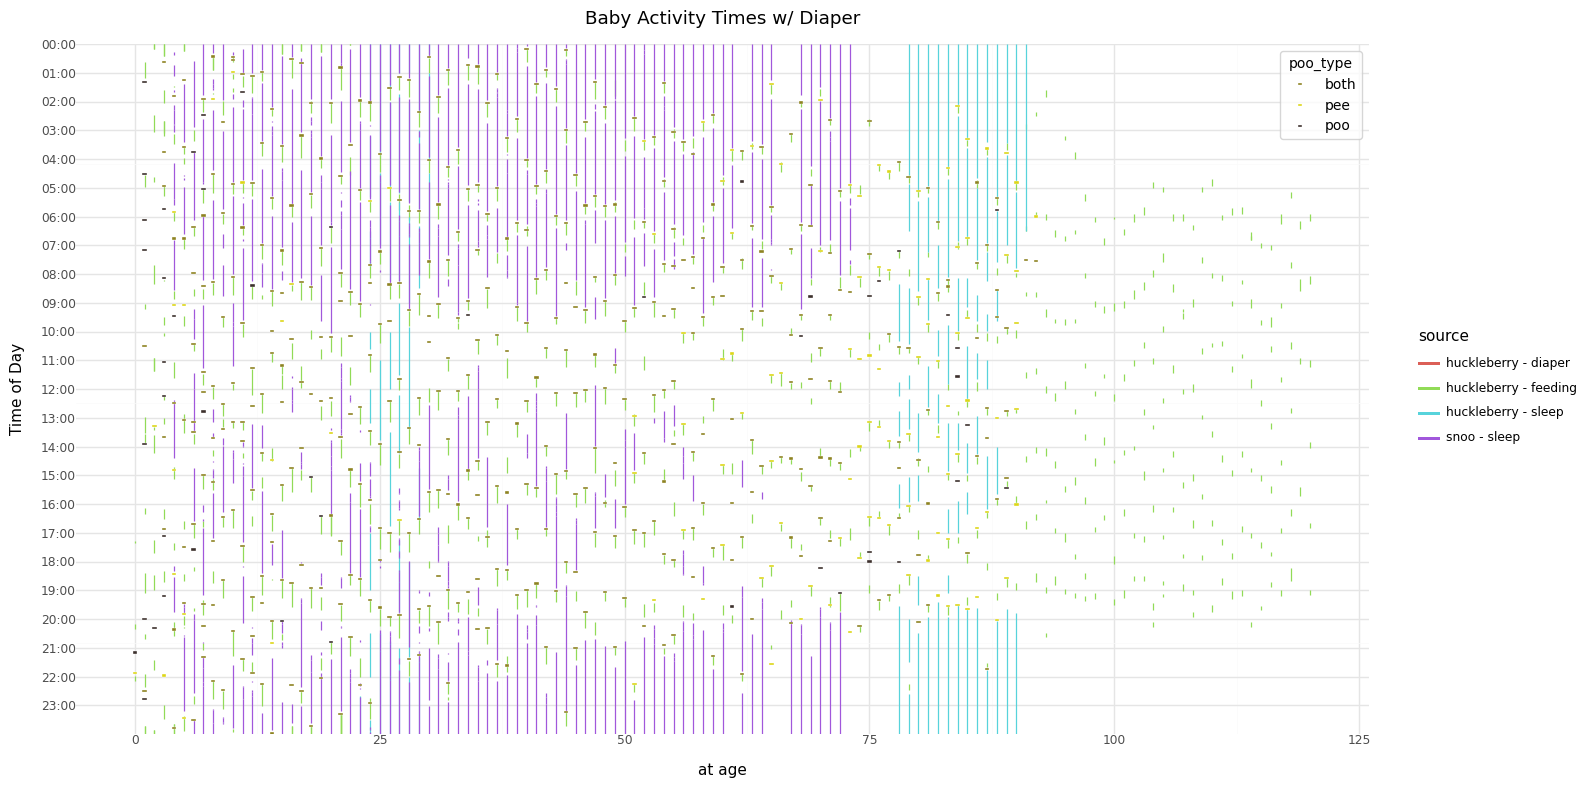

In [144]:
plot = (ggplot(mapping=aes(x='age'), data=df_combined)
        + geom_linerange(aes(ymin='start_time_minutes', ymax='end_time_minutes', color='source'))
        + scale_x_continuous(name='at age', limits=(0, 120))
        + scale_y_continuous(name='Time of Day', expand=(0, 0), limits=(0, 1440))  # Continuous scale for minutes
        + ggtitle('Baby Activity Times w/ Diaper')
        + theme_minimal()
        + theme(plot_background=element_rect(color='white'), figure_size=(16, 8))
)
fig = plot.draw()

ax = fig.axes[0]

ticks = np.arange(0, 1440, 60) 
ax.set_yticks(ticks)


time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in ticks]
ax.set_yticklabels(time_labels)


ax.grid(True)
ax.invert_yaxis()
ax.set_xlabel('') 
ax.set_ylabel('')
ax2 = sns.scatterplot(data=df_poo, x='age', y='start_time_minutes', hue='poo_type',marker='$\u25AC$',palette=['#8D8322', '#DDD618', '#3C302C'], ax=fig.gca(), s=10)
ax2.set_xlabel('') 
ax2.set_ylabel('')

fig.savefig('baby_sleep_times.png', bbox_inches='tight')

Image.open('baby_sleep_times.png')

